In [1]:
!pip install transformers

     |████████████████████████████████| 1.8MB 18.1MB/s 
     |████████████████████████████████| 3.2MB 44.3MB/s 
     |████████████████████████████████| 890kB 55.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e9178aae0b106bf8c829bdc62db99e3d559d42909f1cf6e59c8b170eecfe9b68
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip

--2021-02-14 12:49:52--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.250.28
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.250.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  98.2MB/s    in 2.5s    

2021-02-14 12:49:54 (98.2 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

--2021-02-14 12:49:55--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.146.243
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.146.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  46.4MB/

In [3]:
!unzip -q annotations_trainval2014.zip -d annotations
!unzip -q train2014.zip -d train

In [4]:
!rm -f train2014.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchtext
import torchvision
import torchvision.transforms as T
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, \
                               pad_sequence

from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import transformers as ppb

from google.colab import output as output_colab
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import random
import nltk
import gensim
import gensim.downloader as api
import string
import numpy as np
import pickle
import os

from collections import Counter

#Data

In [7]:
annotation = json.load(open('/content/annotations/annotations/captions_train2014.json'))

In [8]:
df1 = pd.DataFrame(annotation['annotations']).drop(['id'], axis=1)
df1 = df1.rename(columns={'image_id': 'id', 'caption':'caption'})\
      .groupby('id').agg(list)
df2 = pd.DataFrame(annotation['images'])\
      .drop(['license', 'coco_url', 'height', 
             'width', 'date_captured', 'flickr_url'], axis=1)
df2.index = df2.id
df2 = df2.drop(['id'], axis=1)

In [9]:
df = pd.concat([df1, df2], axis=1, ignore_index=False).dropna().reset_index()

#BPE tokenizer


In [10]:
from transformers import *
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [11]:
tokenizer.add_special_tokens({
      'bos_token': '<|startoftext|>',
      'eos_token': '<|endoftext|>',
      'unk_token': '<|unk|>',
      'pad_token': '<|padoftext|>'
})

2

In [12]:
tokenizer.special_tokens_map

{'bos_token': '<|startoftext|>',
 'eos_token': '<|endoftext|>',
 'pad_token': '<|padoftext|>',
 'unk_token': '<|unk|>'}

In [13]:
tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id, tokenizer.unk_token_id

(50257, 50256, 50258, None)

#Tokenizer


In [ ]:
'''
class Tokenizer():
    def __init__(self, data: list):
        self.sos_token = 'sos'
        self.eos_token = 'eos'
        self.pad_token = 'pad'
        
        self.tokenizer = nltk.WordPunctTokenizer()


    def encode_plus(self, text, padding=False, return_tensors='pt', max_lenght=64):
        tokens = text.split()
        
        tokens = [28069] + [self.vocab.stoi[w] for w in tokens if w in self.vocab.stoi] + [26828]
        if padding: tokens += [10109 for i in range(max_lenght - len(tokens))]

        return torch.LongTensor(tokens[:max_lenght])
    
    def example(self, text, padding=False, return_tensors='pt', max_lenght=64):
        tokens = self.tokenizer.tokenize(text)
        filtered_tokens = [w for w in tokens if all(c not in string.punctuation for c in w)]
        
        tokens = [28069] + [self.vocab.stoi[w] for w in filtered_tokens if w in self.vocab.stoi] + [26828]
        if padding: tokens += [10109 for i in range(max_lenght - len(tokens))]

        return torch.LongTensor(tokens[:max_lenght])
    
    def decode(self, tokens):
        if type(tokens) == torch.Tensor: tokens = tokens.tolist()
        text = [self.vocab.itos[token] for token in tokens if token < len(self.vocab.itos)]
        return ' '.join(text)
'''

In [ ]:
#tokenizer = Tokenizer(list(df['caption'].apply(lambda x: x[0])))

In [ ]:
#tokenizer.encode_plus('punkt is world')

AttributeError: ignored

#Parameters

In [88]:
#@title Select the required parameters
BATCH_SIZE = 2 #@param {type:"slider", min:2, max:2048, step:2}
#@markdown ---
EMBEDDING_SIZE = 384 #@param {type:"slider", min:128, max:2048, step:128}
HIDDEN_SIZE = 512 #@param {type:"slider", min:128, max:2048, step:128}
VOCAB_SIZE = tokenizer.vocab_size + 3
#@markdown ---
GPU = True #@param {type:"boolean"}
device = torch.device('cuda') if GPU else torch.device('cpu')
#@markdown ---
LIMIT_IMAGE = True #@param {type:"boolean"}
MAX_ITERS = 6000 #@param {type:"slider", min:1000, max:82783, step:1000}
MAX_LEN_SENTENCE = 58 #@param {type:"slider", min:10, max:200, step:2}
#@markdown ---

#Preprocessing image

##Encoder

In [15]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = beheaded_inception_v3().train(False)
    
    def forward(self, x):
        # return [bs, 2048]
        return self.model(x)[1]

In [17]:
model_encoder = EncoderCNN().to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


##Preprocessing

In [18]:
tr = T.Compose([
                T.Resize((299, 299)),
                T.ToTensor()
])

In [19]:
data = []
q = 0
for i, line in tqdm(enumerate(df.iterrows()), total=MAX_ITERS):
    if LIMIT_IMAGE:
        if i > MAX_ITERS:
            break
    id, captions, name_img = list(line[1])
    tokenizer_caption = tokenizer.encode_plus(captions[0], return_tensors='pt')
    pil_img = Image.open(os.path.join('/content/train/train2014', name_img))\
            .convert('RGB')
    torch_img = tr(pil_img).to(device)
    embed_img = model_encoder(torch_img.unsqueeze(0)).cpu().detach().numpy()
    data.append([tokenizer_caption, embed_img])
print('num preprocessed images', len(data))

num preprocessed images 6001


#Dataloader

In [20]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()

        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        caption, embed = self.data[idx]
        return torch.FloatTensor(embed), caption

In [21]:
trainset, validset = MyDataset(data[:5000]), MyDataset(data[5000:])

In [22]:
len(trainset), len(validset)

(5000, 1001)

In [23]:
from torch.utils.data import Sampler, RandomSampler

class TextSampler(Sampler):
    def __init__(self, sampler, batch_size=9):
        self.sampler = sampler
        self.batch_size = batch_size

        self.create_mask()
        self.sort_dict()

    def create_mask(self):
        dict_ = dict(zip(list(range(len(self.sampler))), [0 for _ in range(len(self.sampler))]))
        for ix in self.sampler:
            row = self.sampler.data_source[ix][1]
            dict_[ix] = len(row["input_ids"][0])
        self.len_dict = dict_
    
    def sort_dict(self):
        list_ = [(i, j) for i, j in self.len_dict.items()]
        self.sort_list = sorted(list_, key=lambda x: x[1], reverse=True)

    def __iter__(self):
        batch = []
        max_len = 0
        len_ = self.sort_list[0][1]
        for ix in self.sort_list:
            if ix[1] == len_:
                batch.append(ix[0])
            else:
                if len(batch) != 0: yield batch
                batch = [ix[0]]
                len_ = ix[1]
            
            if len(batch) > self.batch_size:
                yield batch
                batch = []

    def __len__(self):
        return len(self.sampler)

In [24]:
def collate_fn(batch):
    imgs = torch.cat([item[0] for item in batch], dim=0)
    lens = [len(item[1]) for item in batch]

    seqs = pad_sequence([item[1].input_ids.squeeze(0) for item in batch], padding_value=50258)

    #pack = pack_padded_sequence(seqs, lens, batch_first=False, enforce_sorted=False)

    return {
        'imgs': imgs,
        'input': seqs
    }

In [25]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

train_sampler = RandomSampler(trainset)
valid_sampler = SequentialSampler(validset)

In [71]:
'''
trainloader = torch.utils.data.DataLoader(
          trainset,
          batch_sampler=TextSampler(train_sampler, batch_size=90),
          num_workers=0,
          collate_fn = collate_fn,
)

validloader = torch.utils.data.DataLoader(
          validset,
          batch_sampler=TextSampler(valid_sampler, batch_size=90),
          num_workers=0,
          collate_fn=collate_fn
)
'''

trainloader = torch.utils.data.DataLoader(
          trainset,
          batch_size=1,
          shuffle=True,
          num_workers=0,
          collate_fn = collate_fn,
)

validloader = torch.utils.data.DataLoader(
          validset,
          batch_size=1,
          shuffle=True,
          num_workers=0,
          collate_fn=collate_fn
)

In [72]:
q = 0
for i in trainloader:
    # print(i['imgs'].shape)
    # print(i['input'].shape)
    q += i['imgs'].size(0)
q

5000

#Train

In [73]:
def train(model, trainloader, validloader, criterion, optimizer, n_epoch):
    train_loss = []
    valid_loss = []
    for epoch in range(n_epoch):
        epoch_loss = 0
        model.train()
        for batch in tqdm(trainloader):
            imgs = batch['imgs'].to(device)
            captions = batch['input'].to(device)

            output = model(imgs, captions)

            loss = criterion(output.reshape(-1, VOCAB_SIZE), captions.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(trainloader)
        train_loss.append(epoch_loss)

        epoch_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(validloader):
                imgs = batch['imgs'].to(device)
                captions = batch['input'].to(device)

                output = model(imgs, captions)
                
                loss = criterion(output.reshape(-1, VOCAB_SIZE), captions.reshape(-1))
                epoch_loss += loss.item()
        
        epoch_loss /= len(validloader)
        valid_loss.append(epoch_loss)

        output_colab.clear()
        plt.plot(train_loss, label='train loss')
        plt.plot(valid_loss, label='valid loss')
        plt.legend()
        plt.show()

        test_no_image()

def test(imgs, captions, model):
    img = imgs[0]
    caption = captions[:, 0]

    output = model(img.unsqueeze(0), caption.unsueeze(1))


def test_no_image():
    import time
    model.eval()
    with torch.no_grad():
        for batch in tqdm(validloader):
            img = batch['imgs'].to(device)
            y = batch['input'].to(device)

            out = model(img)
            out = out.max(2)[1]

            out2 = model(img, y)
            out2 = out2.max(2)[1]
            
            #plt.imshow(img.detach().cpu().numpy()[0].transpose(1, 2, 0))
            print("True caption:", tokenizer.decode(y[:, 0].tolist()))
            print("Predict caption with no caption:", tokenizer.decode(out[0].tolist()))
            print("Predict caption with caption:", tokenizer.decode(out2[0].tolist()))
            del img
            del y
            del out
            break

# Model(не работает)

## Encoder


In [ ]:
class Encoder(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.fc = nn.Linear(2048, emb_size)
    
    def forward(self, x):
        x = self.fc(x)
        return x

## Decoder


In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(input_size = embed_size,hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        # features shape: [bs, emb_size]
        # captions, length = pad_packed_sequence(captions)
        captions = captions.permute(1, 0).unsqueeze(2)
        # [bs, len_seq, 1]
        
        captions = captions[:, :-1]
        embed = self.embedding_layer(captions).squeeze(2)
        # [bs, len_seq - 1, emb_size]
        
        embed = torch.cat((features.unsqueeze(1), embed), dim = 1)
        # [bs, len_seq, emb_size]
        
        lstm_outputs, _ = self.lstm(embed)
        # [bs, len_seq , hid_size]
        
        out = self.linear(lstm_outputs)
        # [bs, len_seq , vocab_size]
        
        return out
    
    def sample(self, inputs, states=None, max_len=20):
        output_sentence = torch.zeros(inputs.size(0), max_len, self.vocab_size, device=device)
        
        inputs = inputs.unsqueeze(1)
        # [bs, 1, emb_size]

        for i in range(max_len):
            lstm_outputs, states = self.lstm(inputs, states)
            # [bs, 1, hid_size]

            lstm_outputs = lstm_outputs.squeeze(1)
            # [bs, hid_size]

            out = self.linear(lstm_outputs)
            # [bs, vocab_size]
            last_pick = out.max(1)[1]
            # [bs]
            output_sentence[:, i, :] = out
            inputs = self.embedding_layer(last_pick).unsqueeze(1)
        
        return output_sentence

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()

        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)
    
    def forward(self, img, captions):
        features = self.encoder(img)
        logits = self.decoder(features, captions)
        return logits
    
    def forward_with_no_captions(self, img):
        features = self.encoder(img)
        logits = self.decoder.sample(features)
        return logits

#Model2(не работает)

##Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.fc = nn.Linear(2048, emb_size)
    
    def forward(self, x):
        x = self.fc(x)
        return x

##Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size,
                            num_layers = 2, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_, lstm_state):
        embedded = F.dropout2d(self.embedding(input_))

        output, lstm_state = self.lstm(embedded, lstm_state)

        return self.linear(output), lstm_state

##Model

In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size):
        super().__init__()

        self.vocab_size = vocab_size

        self.encoder = Encoder(emb_size)
        self.decoder = Decoder(emb_size, hidden_size, vocab_size)

        self.init_ = nn.Linear(emb_size, hidden_size)
    

    def init_lstm(self, features):
        #input: [bs, emb_size]
        #output: [num_layers, bs, hidden_size]

        num_layers = self.decoder.lstm.num_layers
        features = self.init_(features).unsqueeze(0)
        #[bs, hidden_size]
        features = features.repeat(num_layers, 1, 1)
        #[num_layers, bs, hidden_size]

        return features, torch.zeros(num_layers, features.size(1), features.size(2), device=device)


    def forward(self, img, captions=None, len_=30):
        features = self.encoder(img)
        # features shape: [bs, emb_size]
        if captions is not None: 
            captions = captions.permute(1, 0).unsqueeze(2)
            # [bs, len_seq, 1]

        bs = features.size(0)
        seq_len = captions.size(1) if captions is not None else len_
        lstm_state = self.init_lstm(features)

        outputs = torch.ones(bs, seq_len, self.vocab_size, device=device).fill_(50257)
        input_ = torch.ones(bs, 1, dtype=torch.long, device=device).fill_(50257)

        for t in range(1, seq_len):
            output, lstm_state = self.decoder(input_, lstm_state)
            outputs[:, t, :] = output.squeeze(1)

            input_ = captions[:, t, :] if captions is not None else output.max(2)[1]
        return outputs

#Model3(работает, но с батчем 1)


##Encoder

In [74]:
class Encoder(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.fc = nn.Linear(2048, emb_size)
    
    def forward(self, x):
        x = self.fc(x)
        return x

##Decoder

In [89]:
class Decoder(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size):
        super().__init__()

        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size,
                            num_layers = 2, batch_first = True)
        
        #self.attention = Attention(emb_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, caption, features):
        
        embedded = F.dropout2d(self.embedding(caption), 0.2).squeeze(2)
        #[bs, seq_len, emb_size]
        input_ = torch.cat([features.unsqueeze(1), embedded[:, :-1, :]], dim=1)
        output, lstm_state = self.lstm(input_)

        return self.linear(output)
    
    def sample(self, features, len_=30):
        outputs = torch.zeros(features.size(0), len_, self.vocab_size)

        lstm_state = None

        input_ = features.unsqueeze(1)
        for i in range(len_):
            output, lstm_state = self.lstm(input_, lstm_state)
            output = self.linear(output)
            outputs[:, i, :] = output.squeeze(1)

            max_pick = output.max(2)[1]
            input_ = F.dropout2d(self.embedding(max_pick), 0.2)

        return outputs

##Model


In [90]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size):
        super().__init__()

        self.encoder = Encoder(emb_size)
        self.decoder = Decoder(emb_size, hidden_size, vocab_size)

    def forward(self, img, captions=None, len_=30):
        features = self.encoder(img)
        # features shape: [bs, emb_size]
        if captions is not None: 
            captions = captions.permute(1, 0).unsqueeze(2)
            # [bs, len_seq, 1]
            output = self.decoder(captions, features)
        else:
            output = self.decoder.sample(features)
            
        return output

# Train

In [91]:
device = torch.device('cuda')

In [92]:
model = Model(EMBEDDING_SIZE, HIDDEN_SIZE, VOCAB_SIZE).to(device)

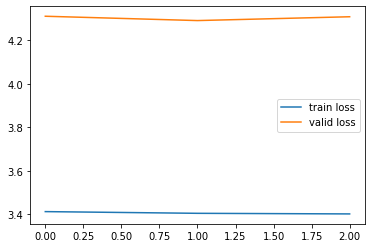

True caption: A young boy poses with a book while a dog looks on.
Predict caption with no caption: A man holding a woman sitting a game. .                  
Predict caption with caption: A man boy sitting a a man and on dog...


KeyboardInterrupt: ignored

In [87]:
criterion = nn.CrossEntropyLoss(ignore_index=50258)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7)
train(model, trainloader, validloader, criterion, optimizer, 20)

In [84]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model4.pth')

самая лучшая модель:
https://drive.google.com/file/d/1-0mQXIgr_iabYM9mO5Pk2Ah50lS_5mqY/view?usp=sharing

In [96]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model2.pth'))

<All keys matched successfully>

In [97]:
test_no_image()

True caption: A girl poses in front of an elephant in a walled enclosure
Predict caption with no caption: A man riding a horse of a horse.    .      is on the back of a man.  
Predict caption with caption: A man is on a of a elephant. a field..


#Tests

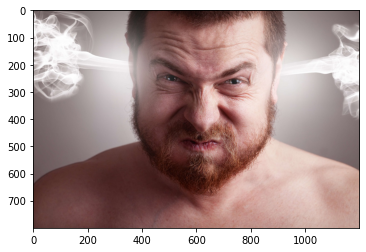

Predict caption: A man is laying a dog with a bed. a dog.       on. .   . 


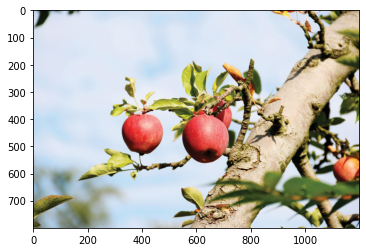

Predict caption: A large white plate with a large green of food.       on it.   .   
.


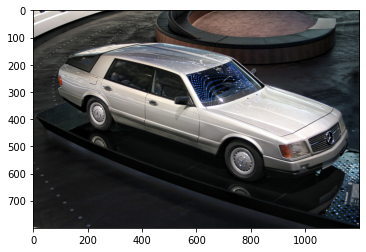

Predict caption: A black is a a motorcycle on a street.        is on on the of a street.     


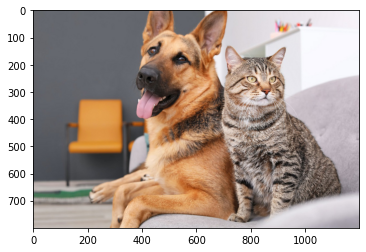

Predict caption: A cat is laying on a bed.  .       on the back of a man.   .


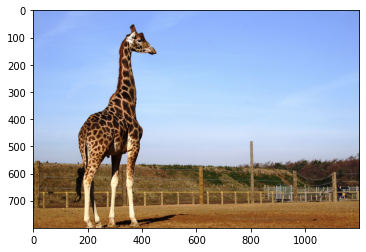

Predict caption: A giraffe standing next to a other on a field. ..       is on the back of a horse.


In [98]:
paths = [
  '/content/drive/MyDrive/angry_man.jpg',
  '/content/drive/MyDrive/apple.jpeg',
  '/content/drive/MyDrive/auto.jpg',
  '/content/drive/MyDrive/dog_cat.jpg',
  '/content/drive/MyDrive/giraffe.jpg'
]

with torch.no_grad():
    for path in paths:
        pil_img = Image.open(path).convert('RGB')
        torch_img = tr(pil_img).to(device)
        embed_img = model_encoder(torch_img.unsqueeze(0)).detach()
        logits = model(embed_img)
        logits = logits.max(2)[1]

        plt.imshow(np.asarray(pil_img))
        plt.show()
        print("Predict caption:", tokenizer.decode(logits[0].tolist()))